The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head(10)

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
1992-06-01,9182
1992-07-01,9103
1992-08-01,10513
1992-09-01,9573


In [5]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

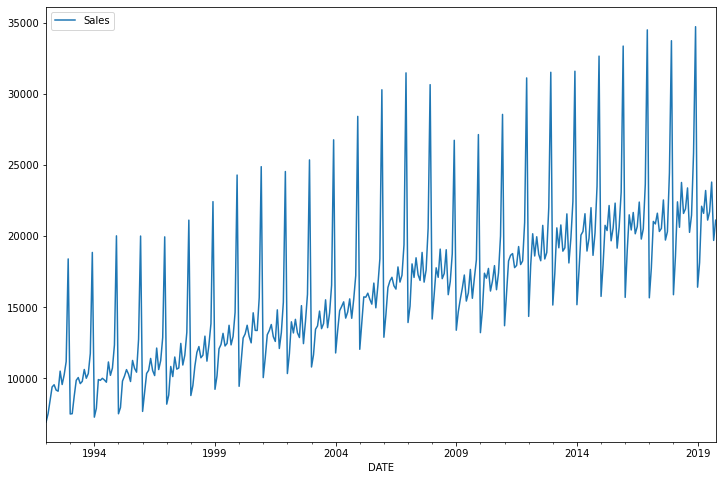

In [6]:
df.plot(figsize=(12,8))

In [7]:
len(df)

334

In [8]:
test_size = 18           # two years for test data

In [9]:
test_ind = len(df) - test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train.shape

(316, 1)

In [12]:
test.shape

(18, 1)

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [18]:
X,y = generator[0]

In [19]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
n_features = 1

In [22]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [26]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [27]:
model.fit(generator,epochs=20,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0256 - val_loss: 0.0026
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0173 - val_loss: 0.0075
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0131 - val_loss: 0.0019
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 5/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0037 - val_loss: 9.0563e-04
Epoch 6/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 4.8608e-04
Epoch 7/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 9/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 5.5540e-04
Epoch 10/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0018 - val_

In [28]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

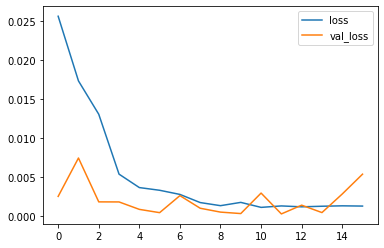

In [29]:
losses.plot()

In [30]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

C:\Users\MASADS~1\AppData\Local\Temp/ipykernel_5632/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [33]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,19460.440014
2018-06-01,21589,18627.185228
2018-07-01,21919,18704.917181
2018-08-01,23381,20007.222501
2018-09-01,20260,18069.564726
2018-10-01,21473,18422.568137
2018-11-01,25831,21532.965116
2018-12-01,34706,29891.083240
2019-01-01,16410,14608.495622


<AxesSubplot:xlabel='DATE'>

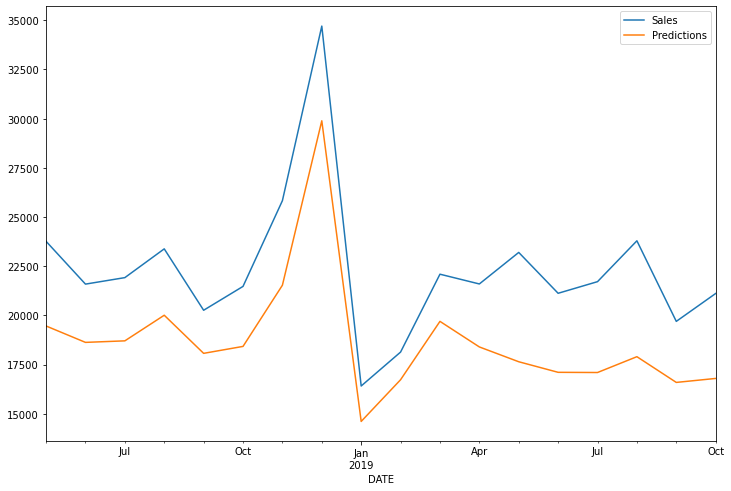

In [34]:
test.plot(figsize=(12,8))

In [35]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [36]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [37]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


model.fit(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 2s 4ms/step - loss: 0.0281
Epoch 2/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0176
Epoch 3/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0126
Epoch 4/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 5/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 6/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0028
Epoch 7/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 8/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0017


In [38]:
forecast = []
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [39]:
forecast = scaler.inverse_transform(forecast)

In [40]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [41]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [42]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

<AxesSubplot:>

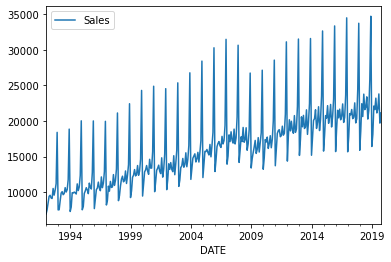

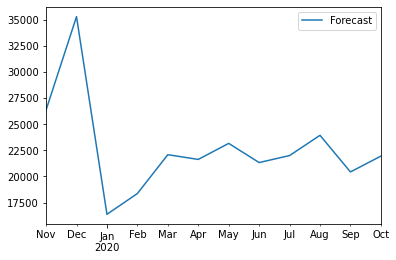

In [43]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

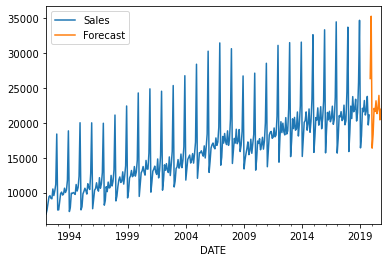

In [44]:
ax = df.plot()
forecast_df.plot(ax=ax)